In [25]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [26]:
# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

# Configure GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Configured {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

GPU Available:  []
Built with CUDA:  False


In [27]:
base_dir = r"/Users/charinduliyanage17/Documents/GitHub/Research_Test/Dataset"

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')

In [28]:
IMG_SIZE = (224, 224) # MobileNetV2 was trained on 224x224 images
BATCH_SIZE = 32       # How many images to process at once

# Load the Eye Data
# automatically find 'Open_Eyes' and 'Closed_Eyes'

IMG_SIZE = (224, 224)  # You can adjust this
BATCH_SIZE = 32  # Reduced batch size for better performance

In [29]:
# Enhanced model architecture
def create_enhanced_model(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # First Conv Block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Second Conv Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Third Conv Block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Fourth Conv Block
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Global Average Pooling instead of Flatten to reduce parameters
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers with dropout for regularization
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    outputs = layers.Dense(4, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model


In [30]:
# Load data with enhanced preprocessing
print("\nLoading training data...")
train_eye_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123 
)

print("Loading validation data...")
val_eye_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)


Loading training data...
Found 8548 files belonging to 4 classes.
Loading validation data...
Found 1554 files belonging to 4 classes.


In [31]:
# Add data augmentation for training data
def augment_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image, label

def normalize_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [32]:
# Apply augmentation to training dataset
train_eye_dataset = train_eye_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
val_eye_dataset = val_eye_dataset.map(normalize_data, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
# Optimize dataset performance
train_eye_dataset = train_eye_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_eye_dataset = val_eye_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [34]:
# Create the enhanced model
print("Creating enhanced model...")
eye_model = create_enhanced_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Compile the model with improved optimizer settings
eye_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ), 
    loss='categorical_crossentropy', 
    # metrics=['accuracy', 'top_2_accuracy']  # Added top-2 accuracy for better evaluation --- IGNORE ---
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]  # Added top-2 accuracy using the correct metric class
)

# Print model summary
eye_model.summary()

Creating enhanced model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,473,572 (5.62 MB)

 Trainable params: 1,471,076 (5.61 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [24]:
# Define callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_eye_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Set enhanced training parameters
EPOCHS = 10  # Increased epochs with early stopping

print(f"Starting training for up to {EPOCHS} epochs with callbacks...")

history = eye_model.fit(
    train_eye_dataset,
    epochs=EPOCHS,
    validation_data=val_eye_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")

Starting training for up to 10 epochs with callbacks...
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5316 - loss: 1.2902 - top_2_accuracy: 0.8090
Epoch 1: val_accuracy improved from -inf to 0.25547, saving model to best_eye_model.h5

Epoch 1: val_accuracy improved from -inf to 0.25547, saving model to best_eye_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.5318 - loss: 1.2895 - top_2_accuracy: 0.8091 - val_accuracy: 0.2555 - val_loss: 1.9517 - val_top_2_accuracy: 0.6300 - learning_rate: 0.0010
Epoch 2/10
Epoch 2/10
 99/268 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.6719 - loss: 0.8267 - top_2_accuracy: 0.9030

KeyboardInterrupt: 

In [35]:
# Define callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_eye_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Set enhanced training parameters
EPOCHS = 10  # Increased epochs with early stopping

print(f"Starting training for up to {EPOCHS} epochs with callbacks...")

# Train on GPU (TensorFlow will automatically use GPU if available)
history = eye_model.fit(
    train_eye_dataset,
    epochs=EPOCHS,
    validation_data=val_eye_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")

Starting training for up to 10 epochs with callbacks...
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5184 - loss: 1.3549 - top_2_accuracy: 0.7954
Epoch 1: val_accuracy improved from -inf to 0.44208, saving model to best_eye_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.5186 - loss: 1.3540 - top_2_accuracy: 0.7957 - val_accuracy: 0.4421 - val_loss: 1.8881 - val_top_2_accuracy: 0.5174 - learning_rate: 0.0010
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6849 - loss: 0.7851 - top_2_accuracy: 0.9092
Epoch 2: val_accuracy improved from 0.44208 to 0.51351, saving model to best_eye_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.6849 - loss: 0.7850 - top_2_accuracy: 0.9092 - val_accuracy: 0.5135 - val_loss: 0.9476 - val_top_2_accuracy: 0.8668 - learning_rate: 0.0010
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7472 - loss: 0.6168 - top_2_accuracy: 0.9370
Epoch 3: val_accuracy did not improve from 0.51351
268/268 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.7472 - loss: 0.6167 - top_2_accuracy: 0.9370 - val_accuracy: 0.5071 - val_loss: 1.2283 - val_top_2_accuracy: 0.7413 - learning_rate: 0.0010
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8197 - loss: 0.4990 - top_2_accuracy: 0.9450
Epoch 4: val_accuracy improved from 0.51351 to 0.87066, saving model to best_eye_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.8198 - loss: 0.4989 - top_2_accuracy: 0.9450 - val_accuracy: 0.8707 - val_loss: 0.3591 - val_top_2_accuracy: 0.9736 - learning_rate: 0.0010
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8638 - loss: 0.3970 - top_2_accuracy: 0.9568
Epoch 5: val_accuracy did not improve from 0.87066
268/268 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.8639 - loss: 0.3969 - top_2_accuracy: 0.9568 - val_accuracy: 0.7284 - val_loss: 0.8490 - val_top_2_accuracy: 0.8591 - learning_rate: 0.0010
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8732 - loss: 0.3533 - top_2_accuracy: 0.9642
Epoch 6: val_accuracy did not improve from 0.87066
268/268 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.8732 - loss: 0.3533 - top_2_accuracy: 0.9642 - val_accuracy: 0.6570 - val_loss: 0.7919 - val_top_2_accuracy: 0.9627 - learning_rate: 0.0010
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8766 - loss: 0.3504 - top

268/268 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.8766 - loss: 0.3503 - top_2_accuracy: 0.9694 - val_accuracy: 0.9028 - val_loss: 0.3354 - val_top_2_accuracy: 0.9833 - learning_rate: 0.0010
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8974 - loss: 0.2893 - top_2_accuracy: 0.9750
Epoch 8: val_accuracy did not improve from 0.90283
268/268 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.8974 - loss: 0.2894 - top_2_accuracy: 0.9750 - val_accuracy: 0.8102 - val_loss: 1.0110 - val_top_2_accuracy: 0.8932 - learning_rate: 0.0010
Epoch 9/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8947 - loss: 0.2931 - top_2_accuracy: 0.9725
Epoch 9: val_accuracy did not improve from 0.90283
268/268 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - accuracy: 0.8947 - loss: 0.2930 - top_2_accuracy: 0.9725 - val_accuracy: 0.8784 - val_loss: 0.3532 - val_top_2_accuracy: 0.9588 - learning_rate: 0.0010
Epoch 10/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9127 - loss: 0.2447 - to

In [36]:
# Plot the results (Accuracy and Loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Use actual number of epochs

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

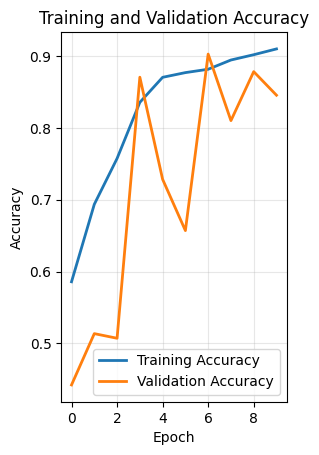

In [37]:
# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

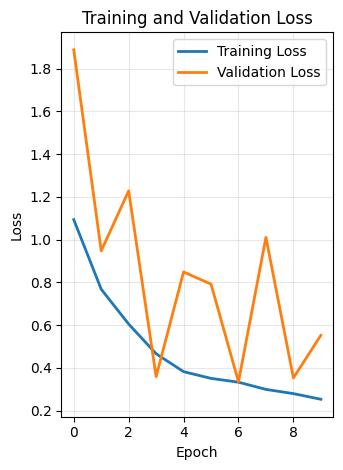

In [38]:
# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)


# Show the plots
plt.tight_layout()
plt.show()

Generating predictions for validation set...
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 363ms/step

Class names: ['Class_0', 'Class_1', 'Class_2', 'Class_3']


2025-11-15 12:08:28.950552: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


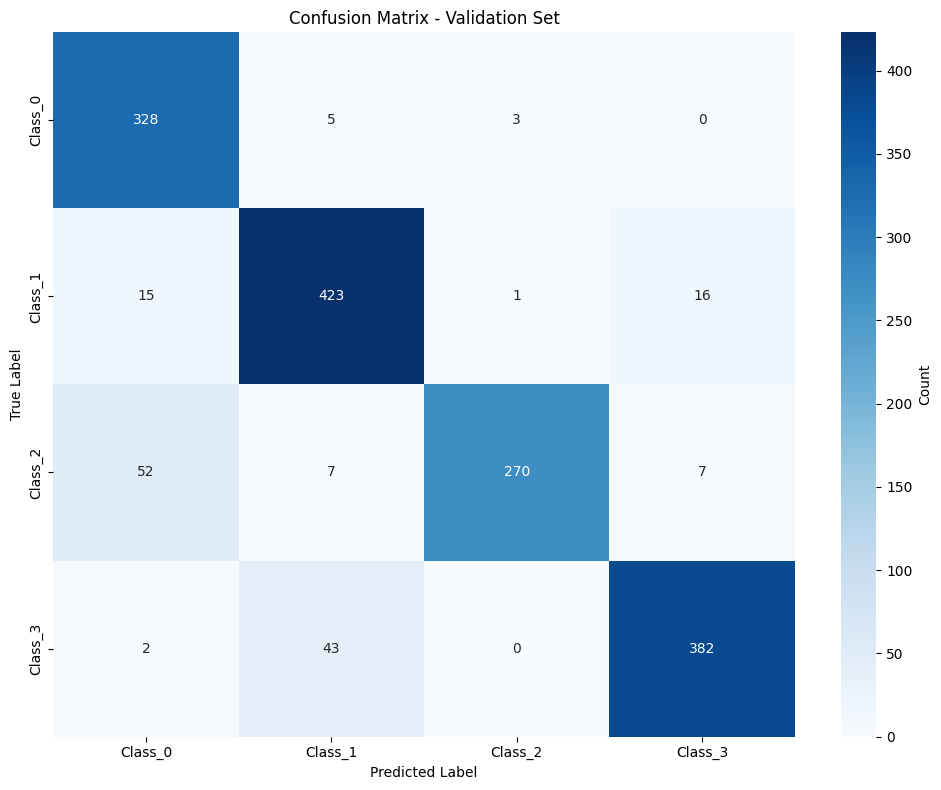

In [39]:
# Generate predictions and evaluation metrics
print("Generating predictions for validation set...")
y_pred_probs = eye_model.predict(val_eye_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from validation dataset
y_true = []
for images, labels in val_eye_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Ensure we have the right number of labels
y_true = y_true[:len(y_pred)]  # Make sure lengths match

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names (if available)
try:
    class_names = val_eye_dataset.class_names
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(4)]
except:
    class_names = [f'Class_{i}' for i in range(4)]

print("\nClass names:", class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [40]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Print final accuracy
final_accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"\nFinal Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")


Classification Report:
              precision    recall  f1-score   support

     Class_0       0.83      0.98      0.89       336
     Class_1       0.88      0.93      0.91       455
     Class_2       0.99      0.80      0.89       336
     Class_3       0.94      0.89      0.92       427

    accuracy                           0.90      1554
   macro avg       0.91      0.90      0.90      1554
weighted avg       0.91      0.90      0.90      1554


Final Accuracy: 0.9028 (90.28%)
